In [1]:
%matplotlib inline

from difflib import SequenceMatcher

import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss

In [226]:
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["figure.facecolor"] = "white"

In [2]:
rym_top_500 = pd.read_csv("../data/rym_top_500_albums.tsv", sep="\t", index_col=0)
rym_top_500.head()

,album_id,artist,name,date,genres,rating,num_ratings,num_reviews
position,,,,,,,,
1,Album45,Radiohead,Ok Computer,1997,"Alternative Rock, Art Rock",4.23,60527,1583
2,Album46,Radiohead,Kid A,2000,"Art Rock, Experimental Rock, Electronic",4.23,50279,714
3,Album976,Pink Floyd,The Dark Side Of The Moon,1973,"Art Rock, Progressive Rock",4.23,50633,1524
4,Album974,Pink Floyd,Wish You Were Here,1975,"Progressive Rock, Art Rock",4.29,41760,939
5,Album2328,King Crimson,In The Court Of The Crimson King,1969,"Progressive Rock, Art Rock",4.31,37873,828


In [3]:
rs_top_500 = pd.read_csv("../data/rs_top_500_albums.tsv", sep="\t", index_col=0)
rs_top_500 = rs_top_500.replace(19755, 1975) # site has one entry as 19755
print(rs_top_500.shape)
rs_top_500.head()

(500, 3)


,artist,name,date
position,,,
1,Marvin Gaye,What'S Going On,1971
2,The Beach Boys,Pet Sounds,1966
3,Joni Mitchell,Blue,1971
4,Stevie Wonder,Songs In The Key Of Life,1976
5,The Beatles,Abbey Road,1969


In [4]:
rs_top_500[rs_top_500["artist"] == "Brian Eno"]

,artist,name,date
position,,,
308,Brian Eno,Here Come The Warm Jets,1974
338,Brian Eno,Another Green World,1975


In [5]:
rym_album_set = set([tuple(row[["artist", "name"]]) for i, row in rym_top_500.iterrows()])
rs_album_set = set([tuple(row[["artist", "name"]]) for i, row in rs_top_500.iterrows()])

In [6]:
both_album_set = rym_album_set.intersection(rs_album_set)
print(len(both_album_set))

157


In [7]:
rym_only = rym_album_set.difference(rs_album_set)
rs_only = rs_album_set.difference(rym_album_set)
print(len(rym_only))
print(len(rs_only))

343
343


Look for albums that are very close to each other.

In [8]:
# create similarity matrix
# rows: rolling stones
# columns: rym
sim_mat = np.zeros([len(rs_only), len(rym_only), 2])
for i, rs_album in enumerate(rs_only):
    for j, rym_album in enumerate(rym_only):
        # sort by decreasing length
        #lambda x: len(x)
        #rs_album = sorted(rs_album, key=lambda x: len(x), reverse=True)
        #rym_album = sorted(rs_album, key=lambda x: len(x), reverse=True)
        
        artist_ratio = SequenceMatcher(None, rs_album[0], rym_album[0]).ratio()
        if artist_ratio >= 0.4 and (rs_album[0] in rym_album[0] or rym_album[0] in rs_album[0]):
            artist_ratio = 1.0
        
        album_ratio = SequenceMatcher(None, rs_album[1], rym_album[1]).ratio()
        if album_ratio >= 0.4 and (rs_album[1] in rym_album[1] or rym_album[1] in rs_album[1]):
            album_ratio = 1.0          
        
        sim_mat[i][j][0] = artist_ratio
        sim_mat[i][j][1] = album_ratio

In [9]:
sim_mat[:, :, 0].shape

(343, 343)

In [10]:
artist_sim_df = pd.DataFrame(sim_mat[:, :, 0])
artist_sim_df.index = rs_only
artist_sim_df.columns = rym_only

album_sim_df = pd.DataFrame(sim_mat[:, :, 1])
album_sim_df.index = rs_only
album_sim_df.columns = rym_only

In [11]:
artist_album_sims = sim_mat.reshape([343*343, 2])
artist_album_sims[:,0]

array([0.23529412, 0.2       , 0.14285714, ..., 0.36363636, 0.22222222,
       0.22222222])

Look for entries w/ artist similarity > 0.6 & artist similarity > 0.6

In [145]:
album_id_combos = list(zip(*np.where((sim_mat[:, :, 0] >= 0.5) & (sim_mat[:, :, 1] >= 0.7))))
album_combos = [(list(rs_only)[i], list(rym_only)[j], sim_mat[i, j, 0], sim_mat[i, j, 1]) for i, j in album_id_combos]
for x in sorted(album_combos, key=lambda x: np.mean(x[2:4])): print(x)
print(len(album_combos))

(('BjöRk', 'Post'), ('Björk', 'Post'), 0.5454545454545454, 1.0)
(('Weezer', 'Weezer (The Blue Album)'), ('Weezer', 'Weezer [Blue Album]'), 1.0, 0.8095238095238095)
(('Elliott Smith', 'Either\\/Or'), ('Elliott Smith', 'Either / Or'), 1.0, 0.8571428571428571)
(('Prince', "Sign O' The Times"), ('Prince', 'Sign "☮" The Times'), 1.0, 0.8571428571428571)
(('The Rolling Stones', 'Exile On Main Street'), ('The Rolling Stones', 'Exile On Main St.'), 1.0, 0.8648648648648649)
(('Led Zeppelin', 'Led Zeppelin Iv'), ('Led Zeppelin', 'Led Zeppelin Iii'), 1.0, 0.9032258064516129)
(('Can', 'Ege Bamyasi'), ('Can', 'Ege Bamyası'), 1.0, 0.9090909090909091)
(('Sly And The Family Stone', "There'S A Riot Goin' On"), ('Sly & The Family Stone', "There'S A Riot Goin' On"), 0.9130434782608695, 1.0)
(('Crosby, Stills, Nash, And Young', 'Déjà Vu'), ('Crosby, Stills, Nash & Young', 'Déjà Vu'), 0.9152542372881356, 1.0)
(('New Order', 'Power, Corruption &Amp; Lies'), ('New Order', 'Power, Corruption & Lies'), 1.0, 0

In [146]:
album_combos.remove((('Led Zeppelin', 'Led Zeppelin Iv'), ('Led Zeppelin', 'Led Zeppelin Iii'), 1.0, 0.9032258064516129))

In [14]:
final_both_album_set = both_album_set.union(set([x[1] for x in album_combos]))
final_rym_only_set = rym_only.copy()
final_rs_only_set = rs_only.copy()

for combo in album_combos:
    final_rym_only_set.remove(combo[1])
    final_rs_only_set.remove(combo[0])

print(len(final_both_album_set))
print(len(final_rs_only_set))
print(len(final_rym_only_set))

192
308
308


In [15]:
final_both_album_set

{('A Tribe Called Quest', 'Midnight Marauders'),
 ('A Tribe Called Quest', 'The Low End Theory'),
 ('Alice Coltrane Featuring Pharoah Sanders', 'Journey In Satchidananda'),
 ('Arcade Fire', 'Funeral'),
 ('Beastie Boys', "Paul'S Boutique"),
 ('Belle And Sebastian', "If You'Re Feeling Sinister"),
 ('Björk', 'Homogenic'),
 ('Björk', 'Post'),
 ('Black Sabbath', 'Black Sabbath'),
 ('Black Sabbath', 'Master Of Reality'),
 ('Black Sabbath', 'Paranoid'),
 ('Bob Dylan', 'Blonde On Blonde'),
 ('Bob Dylan', 'Blood On The Tracks'),
 ('Bob Dylan', 'Bringing It All Back Home'),
 ('Bob Dylan', 'Highway 61 Revisited'),
 ('Bob Dylan', "The Freewheelin' Bob Dylan"),
 ('Bob Marley', 'Exodus'),
 ('Bon Iver', 'For Emma, Forever Ago'),
 ('Bruce Springsteen', 'Born To Run'),
 ('Bruce Springsteen', 'Darkness On The Edge Of Town'),
 ('Bruce Springsteen', 'Nebraska'),
 ('Can', 'Ege Bamyası'),
 ('Charles Mingus', 'Mingus Ah Um'),
 ('Cocteau Twins', 'Heaven Or Las Vegas'),
 ('Creedence Clearwater Revival', "Cosmo

In [58]:
_df1 = rym_top_500.copy()
_df1["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df1.iterrows()]
_df1 = _df1[_df1["artist_name"].isin(["_".join(x) for x in final_rym_only_set])]
_df1 = _df1["date"].value_counts().to_frame().reset_index()
_df1 = _df1.rename(columns={"index": "date", "date": "count"})
_df1 = _df1.set_index("date")

_df2 = rs_top_500.copy()
_df2["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df2.iterrows()]
_df2 = _df2[_df2["artist_name"].isin(["_".join(x) for x in final_rs_only_set])]
_df2 = _df2["date"].value_counts().to_frame().reset_index()
_df2 = _df2.rename(columns={"index": "date", "date": "count"})
_df2 = _df2.set_index("date")

_df3 = rym_top_500.copy()
_df3["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df3.iterrows()]
_df3 = _df3[_df3["artist_name"].isin(["_".join(x) for x in final_both_album_set])]
_df3 = _df3.groupby(["date"]).size().to_frame()
_df3 = _df3.rename(columns={0: "count"})
#_df3 = _df3.reset_index()

year_df = _df1.join(_df2, lsuffix="_RYM", rsuffix="_RS", how="outer").join(_df3, how="outer").fillna(0)
year_df = year_df.rename(columns={"count": "count_BOTH"})
year_df["sum"] = year_df.sum(axis=1)
year_df = year_df.sort_index()
year_df

,count_RYM,count_RS,count_BOTH,sum
date,,,,
1955,0.0,1.0,0.0,1.0
1956,0.0,1.0,0.0,1.0
1957,1.0,1.0,0.0,2.0
1958,3.0,2.0,0.0,5.0
1959,2.0,1.0,3.0,6.0
...,...,...,...,...
2016,8.0,4.0,1.0,13.0
2017,4.0,2.0,1.0,7.0
2018,7.0,3.0,0.0,10.0


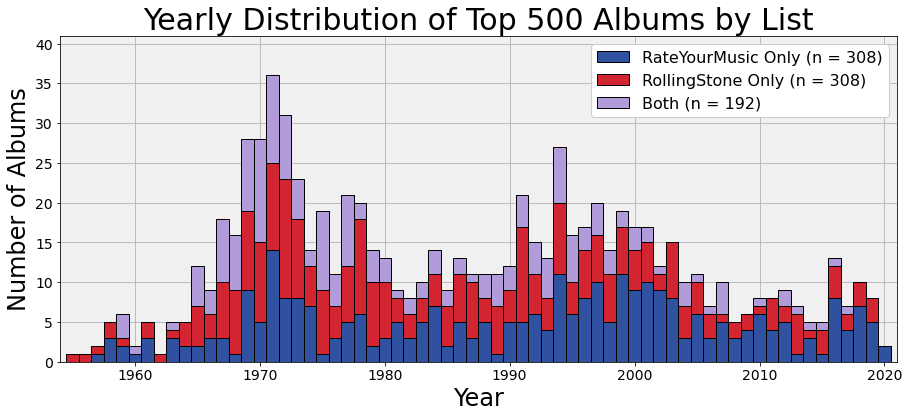

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

color_dict = {
    "count_RYM": "#2F519F",
    "count_RS": "#d32531",
    "count_BOTH": "#b19cd9"
}

min_year = min(rym_top_500["date"].min(), rs_top_500["date"].min())
max_year = max(rym_top_500["date"].max(), rs_top_500["date"].max())

for i, col in enumerate(["count_RYM", "count_RS", "count_BOTH"]):
    ax.bar(
        year_df.index,
        year_df[col],
        bottom=np.sum(year_df.values[:, :i], axis=1),
        color=color_dict.get(col),
        label=col,
        width=1,
        edgecolor="black",
        lw=1,
        zorder=2,
    )

ax.set_xlim([min_year-1, max_year+1])
ax.set_ylim([0, 41])
ax.legend(
    labels=[
        f"RateYourMusic Only (n = {len(final_rym_only_set)})", 
        f"RollingStone Only (n = {len(final_rs_only_set)})", 
        f"Both (n = {len(final_both_album_set)})"
    ],
    fontsize=16,
    framealpha=1,
    #frameon=False,
)

ax.tick_params("both", labelsize=14)
ax.set_facecolor("#F0F0F0")
ax.grid(zorder=0)

ax.set_xlabel("Year", fontsize=24)
ax.set_ylabel("Number of Albums", fontsize=24)
ax.set_title("Yearly Distribution of Top 500 Albums by List", fontsize=30)

plt.show()

In [157]:
album_match_dict = {"_".join(x[0]): "_".join(x[1]) for x in album_combos}
print(len(album_match_dict.keys()))
album_match_dict

35


{'Frank Ocean_Blond': 'Frank Ocean_Blonde',
 'Jimi Hendrix_Electric Ladyland': 'The Jimi Hendrix Experience_Electric Ladyland',
 'BjöRk_Post': 'Björk_Post',
 'Otis Redding_Otis Blue': 'Otis Redding_Otis Blue: Otis Redding Sings Soul',
 'Raekwon_Only Built 4 Cuban Linx': 'Raekwon_Only Built 4 Cuban Linx...',
 'Elliott Smith_Either\\/Or': 'Elliott Smith_Either / Or',
 'Bob Marley And The Wailers_Exodus': 'Bob Marley_Exodus',
 'Fela Kuti And Africa 70_Expensive Shit': 'Fela Kuti_Expensive Shit',
 'Weezer_Weezer (The Blue Album)': 'Weezer_Weezer [Blue Album]',
 "Sly And The Family Stone_There'S A Riot Goin' On": "Sly & The Family Stone_There'S A Riot Goin' On",
 'Can_Ege Bamyasi': 'Can_Ege Bamyası',
 'Bon Iver_For Emma': 'Bon Iver_For Emma, Forever Ago',
 'Wu-Tang Clan_Enter The Wu-Tang(36 Chambers)': 'Wu-Tang Clan_Enter The Wu-Tang (36 Chambers)',
 'The Smashing Pumpkins_Siamese Dream': 'Smashing Pumpkins_Siamese Dream',
 'Dj Shadow_Entroducing.....': 'Dj Shadow_Endtroducing.....',
 'Ali

In [160]:
rank_df = rym_top_500.copy()
rank_df["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in rank_df.iterrows()]
rank_df = rank_df[rank_df["artist_name"].isin(["_".join(x) for x in final_both_album_set])]
rank_df = rank_df.reset_index()
rank_df = rank_df.set_index("artist_name", drop=False)
rank_df = rank_df[["position", "rating", "num_ratings", "num_reviews"]]

_df2 = rs_top_500.copy()
_df2["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df2.iterrows()]
_df2 = _df2.replace(album_match_dict)
_df2 = _df2[_df2["artist_name"].isin(["_".join(x) for x in final_both_album_set])]
_df2 = _df2.reset_index()

rank_df = rank_df.join(_df2.set_index("artist_name"), how="inner", lsuffix="_RYM", rsuffix="_RS")
rank_df.head()

,position_RYM,rating,num_ratings,num_reviews,position_RS,artist,name,date
artist_name,,,,,,,,
Radiohead_Ok Computer,1,4.23,60527,1583,42,Radiohead,Ok Computer,1997
Radiohead_Kid A,2,4.23,50279,714,20,Radiohead,Kid A,2000
Pink Floyd_The Dark Side Of The Moon,3,4.23,50633,1524,55,Pink Floyd,The Dark Side Of The Moon,1973
Pink Floyd_Wish You Were Here,4,4.29,41760,939,264,Pink Floyd,Wish You Were Here,1975
The Velvet Underground_The Velvet Underground & Nico,6,4.25,40013,918,23,The Velvet Underground,The Velvet Underground And Nico,1967


In [248]:
pd.interval_range(start=0, freq=10, end=500, closed='left')

IntervalIndex([[0, 10), [10, 20), [20, 30), [30, 40), [40, 50) ... [450, 460), [460, 470), [470, 480), [480, 490), [490, 500)],
              closed='left',
              dtype='interval[int64]')

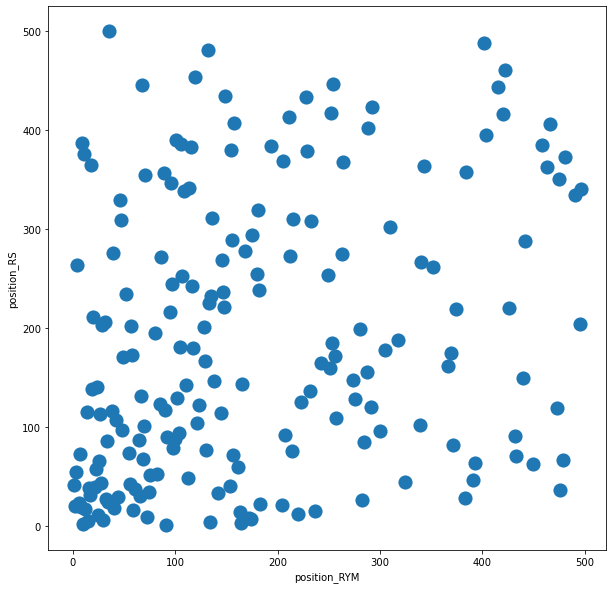

In [240]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.scatterplot(
    data=rank_df,
    x="position_RYM",
    y="position_RS",
    #hue="rating",
    #palette="viridis",
    linewidth=0,
    s=200,
    ax=ax,
    legend=None,
)

plt.show()

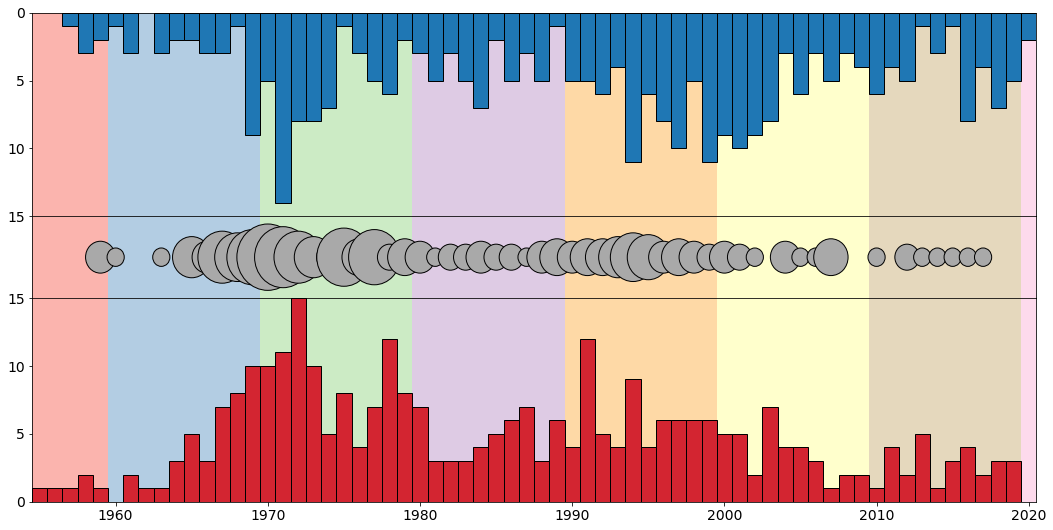

In [103]:
fig = plt.figure(figsize=(18, 9))
heights = [5, 2, 5]
spec = fig.add_gridspec(nrows=3, ncols=1, height_ratios=heights)

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
ax3 = fig.add_subplot(spec[2])

plt.subplots_adjust(hspace=0.0)

min_year = min(rym_top_500["date"].min(), rs_top_500["date"].min())
max_year = max(rym_top_500["date"].max(), rs_top_500["date"].max())

# rym only
_df1 = rym_top_500.copy()
_df1["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df1.iterrows()]
_df1 = _df1[_df1["artist_name"].isin(["_".join(x) for x in final_rym_only_set])]
_df1 = _df1["date"].value_counts().to_frame().reset_index()

#ax1.hist(_df1["date"], bins=max_year-min_year, bottom=0)
ax1.bar(_df1["index"], _df1["date"], width=1, edgecolor="black")
ax1.set_ylim([0, 15])
ax1.set_yticks(np.arange(0, 16, 5))
ax1.invert_yaxis()
ax1.xaxis.set_visible(False)

bg_palette = sns.color_palette("Pastel1", 8)

for ax in [ax1, ax2, ax3]:
    ax.set_xlim([min_year-0.5, max_year+0.5])
    #ax.set_xticks(np.arange(min_year, max_year+1))
    for i, yr in enumerate(np.arange(round(min_year/10)*10-10, round(max_year/10)*10+10, 10)):
        #ax.axvline(x=yr, zorder=0, linestyle="--", color="black")
        ax.axvspan(yr-0.5, yr+10.5, facecolor=bg_palette[i], zorder=0)
        pass

# rolling stones only
_df2 = rs_top_500.copy()
_df2["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df2.iterrows()]
_df2 = _df2[_df2["artist_name"].isin(["_".join(x) for x in final_rs_only_set])]
_df2 = _df2["date"].value_counts().to_frame().reset_index()

ax3.bar(_df2["index"], _df2["date"], width=1, color="#d32531", edgecolor="black")
ax3.set_ylim([0, 15])
ax3.set_yticks(np.arange(0, 16, 5))
ax3.tick_params("both", labelsize=14)

# middle
_df3 = rym_top_500.copy()
_df3["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df3.iterrows()]
_df3 = _df3[_df3["artist_name"].isin(["_".join(x) for x in final_both_album_set])]
_df3 = _df3.groupby(["date"]).size().to_frame()
_df3 = _df3.rename(columns={0: "count"})
_df3 = _df3.reset_index()

#ax2.bar(_df3["date"], _df3["count"], width=1, color="gray", edgecolor="black")

ax2.set_ylim([0, 5])
#ax2.set_xlim([0, 65])
#ax2.axis("equal")

_df3["radius"] = _df3["count"].apply(lambda x: np.sqrt(x/np.pi))

for i, row in _df3.iterrows():
    p = mpatches.Circle(
        (row["date"], ax2.get_ylim()[1]/2),
        radius=row["radius"],
        facecolor="darkgray",
        edgecolor="black",
    )
    ax2.add_patch(p)

ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
    
for ax in [ax1, ax3]:
    ax.tick_params("y", labelsize=14)
    #ax.set_ylabel("# Albums", fontsize=18)

plt.show()